# Fluid Dynamics: finding the optimal Tesla Valve Design

Team 9: Kyrian Puttileihalat, Liam Gatersleben, Pieter Duindam, Sebas van Waard



In [1]:
# python -m ipykernel install \
#  --user \
#  --name pylbm-env \  # CHANGE THIS TO YOUR VENV FOLDER NAME
# --display-name "Python (pylbm-env)"

## 1. Introduction

Fluid control is a central problem in fluid dynamics, particularly in systems where passive, robust flow regulation is desired. One notable example is the *Tesla valve*, a valve geometry designed to strongly resist flow in one direction while allowing relatively unobstructed flow in the opposite direction, without the use of moving parts.

The effectiveness of a Tesla valve depends heavily on its geometric design. Parameters such as valve length, channel diameter, loop spacing, and loop overlap influence how momentum is redirected and dissipated within the valve. Additionally, fluid properties such as flow speed and viscosity play a crucial role in determining overall performance.

In this project, we investigate how variations in Tesla valve geometry affect its ability to restrict reverse flow under different fluid conditions. Using numerical fluid simulations, we aim to identify optimal valve designs for a range of flow speeds and viscosities. A secondary objective is to determine whether loop spacing remains influential in cases where valve loops do not overlap.

The simulations are performed using the Lattice Boltzmann Method, which is well suited for modeling complex boundary geometries and flow behavior in two dimensions.


### Experiment 1

Because the Lattice Boltzmann Method is quite computationally expensive, it is important to minimize the computational power needed. Because of this, the timepoint at which we measure the effectiveness of our valve should be as low as possible.

For the first experiment this is timepoint is what we will look for.

All experiments below will be done for an LBM with parameters:
- la (scheme velocity) = 1.02
- input_vel (input velocity) = 0.015
- Re (Reynolds number) = 20

To find the optimal timepoint we've used a standard Tesla Valve with:
- r = 0.1
- dy (length of loop) = 0.35
- width (diameter of valve) = 0.07

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pylbm

from src.class_test import Simulation
from src.valve_generator import generate_valve

In [2]:
# set simulation paramters
simulaton_params = {
    "png_path": "data/valve.png",
    "visualization_by": "pressure_field",
    "la": 1.02,
    "input_vel": 0.015,
    "Re": 20
    }

In [21]:
def diodicity_over_time(max_t = 10000, start_t = 0, step = 50):
    max_timepoint = max_t
    timepoint = start_t
    timestep = step

    # Create simulations
    sim_fwd = Simulation(flip_x=True, Tf = max_timepoint, **simulaton_params)
    sim_rev = Simulation(flip_x=False, Tf= max_timepoint, **simulaton_params)

    sim_fwd.build_simulation()
    sim_rev.build_simulation()

    diodicities = []
    timepoints = []

    while timepoint < max_timepoint:
        timepoint += timestep
        for _ in range(timestep):
            sim_fwd.sol.one_time_step()
            sim_rev.sol.one_time_step()
        
        fwd_fr = sim_fwd.flow_resistance()
        rev_fr = sim_rev.flow_resistance()

        diodicity = rev_fr / fwd_fr
        print(f"Diodicity at t = {timepoint}: {diodicity}", end="\r")

        diodicities.append(diodicity)
        timepoints.append(timepoint)
    
    return diodicities, timepoints

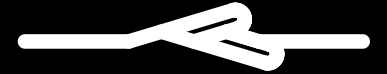

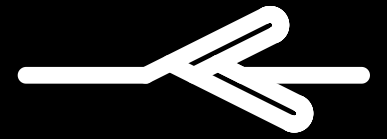

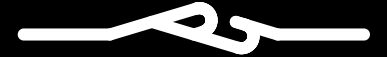

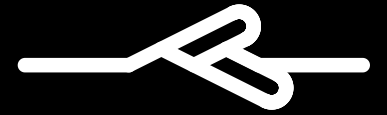

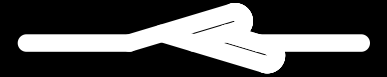

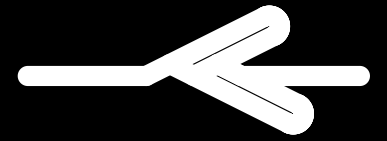

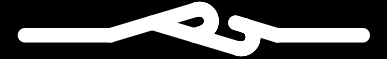

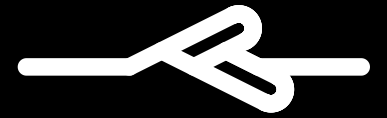

In [22]:
import warnings
import logging

warnings.filterwarnings("ignore", module="pylbm")
warnings.filterwarnings("ignore", message=".*FigureCanvasAgg.*")
logging.getLogger("pylbm").setLevel(logging.ERROR)

widths = [0.07, 0.085]
radii = [0.09, 0.14]
dys = [0.30, 0.50]

diodicities = []
timepoints = []

for width in widths:
    for radius in radii:
        for dy in dys:
            generate_valve(width, 2, dy, radius, 1)
            results = diodicity_over_time()
            diodicities.append(results[0])
            timepoints.append(results[1])
  

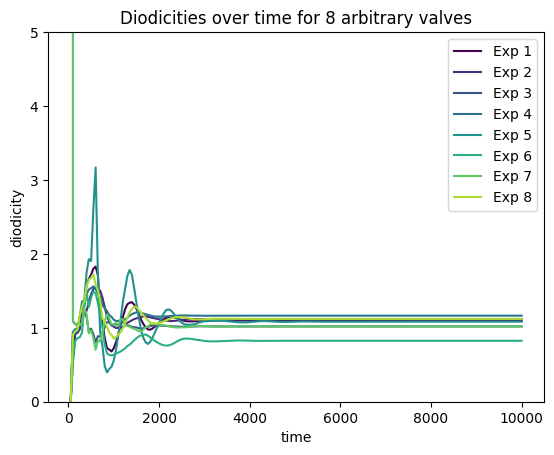

In [32]:
n = len(diodicities)
cmap = plt.get_cmap("viridis")

for i, (x, y) in enumerate(zip(timepoints, diodicities)):
    color = cmap(i / n)  # spread colors evenly
    plt.plot(x, y, color=color, label=f"Exp {i+1}")


plt.xlabel("time")
plt.ylabel("diodicity")
plt.title("Diodicities over time for 8 arbitrary valves")
plt.ylim((0, 5))
plt.legend()
plt.show()

From these results we find that at about t = 4000 the diodacity finds its equilibrium for all tested valves. Therefore we have set our measurement time at t = 4000, resulting in the following parameters:
- la (scheme velocity) = 1.02
- input_vel (input velocity) = 0.015
- Re (Reynolds number) = 20
- Tf (max t) = 4000

In [34]:
sim_params = {
    "png_path": "data/valve.png",
    "visualization_by": "pressure_field",
    "la": 1.02,
    "Tf": 4000,
    "input_vel": 0.015
    }

### Experiment 2

Now that we know at which timpoint we can consistently measure the diodicity of the valve, we can continue our search to find the optimal configuration of the tesla valve.

To start of we will look for the optimal valve diameter, while keeping the parameters of the unit valve the same.

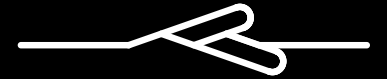

The diodicity for width w = 0.03 is Di = 1.2561854554382446


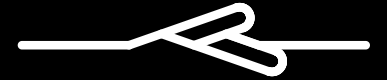

The diodicity for width w = 0.04 is Di = 1.2170037977353054


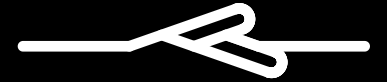

The diodicity for width w = 0.05 is Di = 1.1793610984445089


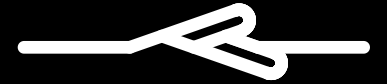

The diodicity for width w = 0.060000000000000005 is Di = 1.1539137484003017


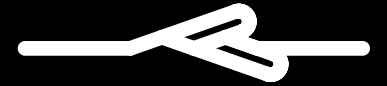

The diodicity for width w = 0.07 is Di = 1.1341721325822824


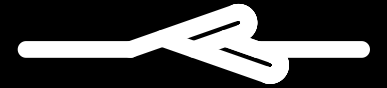

The diodicity for width w = 0.08000000000000002 is Di = 1.1247482474773527


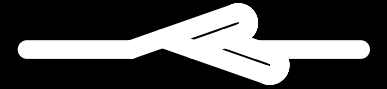

The diodicity for width w = 0.09000000000000001 is Di = 0.7288974291627561


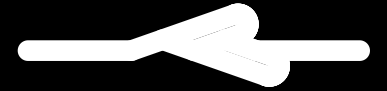

The diodicity for width w = 0.1 is Di = 0.7109152722157339


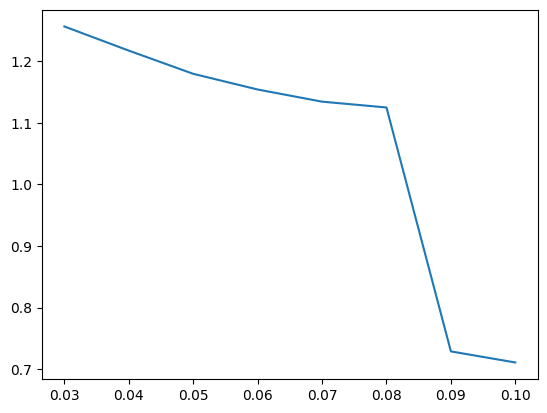

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import logging
plt.close("all")

warnings.filterwarnings("ignore", module="pylbm")
warnings.filterwarnings("ignore", message=".*FigureCanvasAgg.*")
logging.getLogger("pylbm").setLevel(logging.ERROR)

def diodicity(reverse, forward):
    return reverse / forward

width = np.arange(0.03, 0.1, 0.01)
D = []

for w in width:
    generate_valve(w, 2, 0.35, 0.1, 1)

    # Run simulations
    sim_rev = Simulation(flip_x = False, **sim_params)
    sim_for = Simulation(flip_x = True, **sim_params)
    
    sol_for = sim_for.run()
    sol_rec = sim_rev.run()

    # Calculate flow resistance for diodicity
    reverse_res = sim_rev.flow_resistance()
    forward_res = sim_for.flow_resistance()
    # print(f"Reverse Flow resistance at time t = {sim_rev.Tf} is R = {reverse_res}")
    # print(f"Forward Flow resistance at time t = {sim.Tf} is R = {forward_res}")
    
    Diodicity = diodicity(reverse_res, forward_res)
    D.append(Diodicity)
    print(f"The diodicity for width w = {w} is Di = {Diodicity}")

plt.plot(width, D)

### Experiment 4

radius

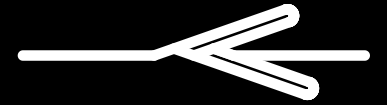

The diodicity for radius r = 0.05 is Di = 1.3519497227502748


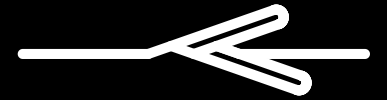

The diodicity for radius r = 0.060000000000000005 is Di = 1.4223653534698766


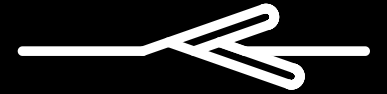

The diodicity for radius r = 0.07 is Di = 1.4075020070554682


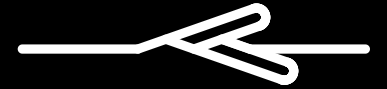

The diodicity for radius r = 0.08000000000000002 is Di = 1.4259179325207083


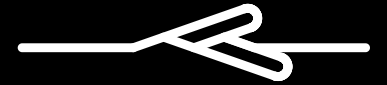

The diodicity for radius r = 0.09000000000000001 is Di = 1.47365903971466


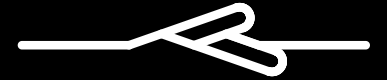

The diodicity for radius r = 0.1 is Di = 1.513370585706788


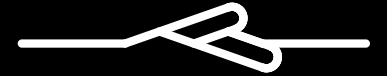

The diodicity for radius r = 0.11000000000000001 is Di = 1.5014760129100002


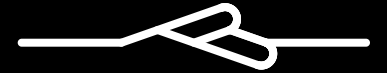

The diodicity for radius r = 0.12000000000000001 is Di = 1.5204686134343433


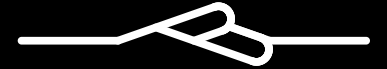

The diodicity for radius r = 0.13 is Di = 1.5690788261691757


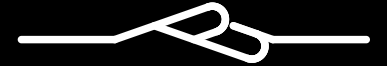

The diodicity for radius r = 0.14 is Di = 1.1540317985950586


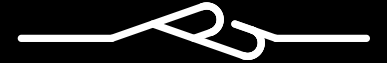

The diodicity for radius r = 0.15000000000000002 is Di = 1.1184284753956648


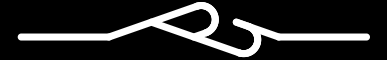

The diodicity for radius r = 0.16000000000000003 is Di = 1.0991026357201104


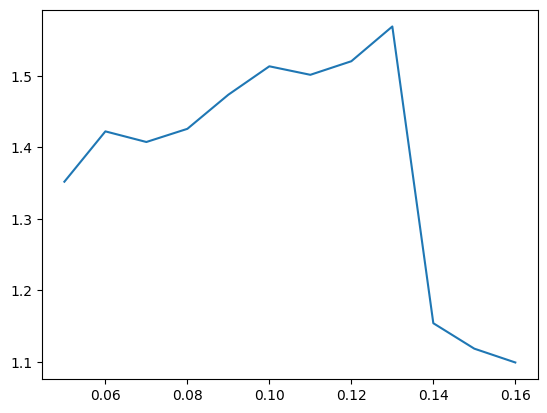

In [ ]:
radius = np.arange(0.05, 0.17, 0.01)
D = []

for r in radius:
    generate_valve(0.04, 2, 0.35, r, 1)
    sim_params = {
        "png_path": "data/valve.png",
        "visualization_by": "pressure_field",
        "la": 1.03,
        "resolution_factor": 1,
        "input_vel": 0.020
        }

    # Run simulations
    sim_rev = Simulation(flip_x = False, **sim_params)
    sim_for = Simulation(flip_x = True, **sim_params)
    # sim.plot_grid()  # uncomment to debug your PNG -> grid parsing
    sol_for = sim_for.run()
    sol_rec = sim_rev.run()

    # sim.animate(nrep=64, interval=0.1)
    # sim_rev.animate(nrep=64, interval=0.1)

    # Calculate flow resistance for diodicity
    reverse_res = sim_rev.flow_resistance()
    forward_res = sim_for.flow_resistance()
    # print(f"Reverse Flow resistance at time t = {sim_rev.Tf} is R = {reverse_res}")
    # print(f"Forward Flow resistance at time t = {sim.Tf} is R = {forward_res}")
    Diodicity = diodicity(reverse_res, forward_res)
    D.append(Diodicity)
    print(f"The diodicity for radius r = {r} is Di = {Diodicity}")

plt.plot(radius, D)

### Experiment 5

dy

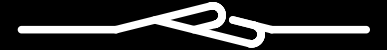

The diodicity for dy = 0.25 is Di = 1.0898829124076979


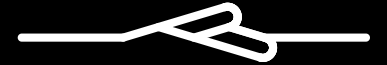

The diodicity for dy = 0.3 is Di = 1.4892648883368216


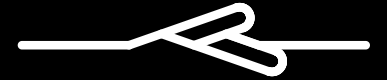

The diodicity for dy = 0.35 is Di = 1.513370585706788


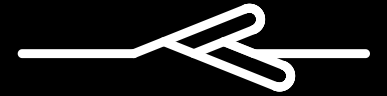

The diodicity for dy = 0.39999999999999997 is Di = 1.535286608950423


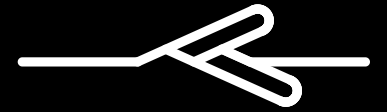

The diodicity for dy = 0.44999999999999996 is Di = 1.4343803239872064


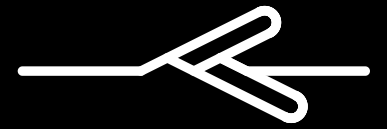

The diodicity for dy = 0.49999999999999994 is Di = 1.458195471734791


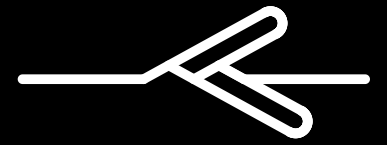

The diodicity for dy = 0.5499999999999999 is Di = 1.423625430160231


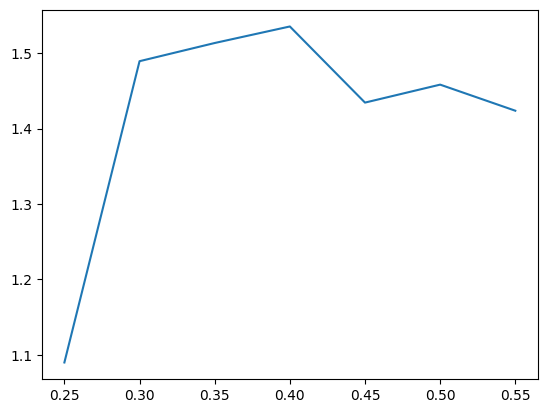

In [ ]:
dy = np.arange(0.25, 0.6, 0.05)
D = []

for y in dy:
    generate_valve(0.04, 2, y, 0.1, 1)
    sim_params = {
        "png_path": "data/valve.png",
        "visualization_by": "pressure_field",
        "la": 1.03,
        "resolution_factor": 1,
        "input_vel": 0.020
        }

    # Run simulations
    sim_rev = Simulation(flip_x = False, **sim_params)
    sim_for = Simulation(flip_x = True, **sim_params)
    # sim.plot_grid()  # uncomment to debug your PNG -> grid parsing
    sol_for = sim_for.run()
    sol_rec = sim_rev.run()

    # sim.animate(nrep=64, interval=0.1)
    # sim_rev.animate(nrep=64, interval=0.1)

    # Calculate flow resistance for diodicity
    reverse_res = sim_rev.flow_resistance()
    forward_res = sim_for.flow_resistance()
    # print(f"Reverse Flow resistance at time t = {sim_rev.Tf} is R = {reverse_res}")
    # print(f"Forward Flow resistance at time t = {sim.Tf} is R = {forward_res}")
    Diodicity = diodicity(reverse_res, forward_res)
    D.append(Diodicity)
    print(f"The diodicity for dy = {y} is Di = {Diodicity}")

plt.plot(dy, D)

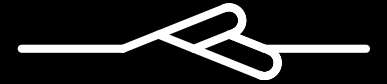

1
[0.04 0.13 0.4 ]
-1.6043677990191039


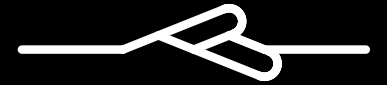

1
[0.042 0.13  0.4  ]
-1.5478422435274868


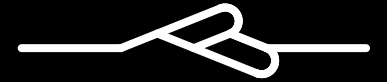

1
[0.04   0.1365 0.4   ]
-1.5580349300506322


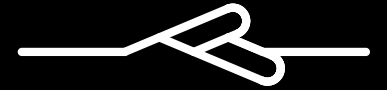

1
[0.04 0.13 0.42]
-1.5303319339962749


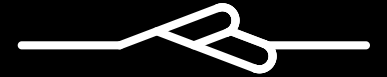

1
[0.04133333 0.13433333 0.38      ]
-1.5651996074730992


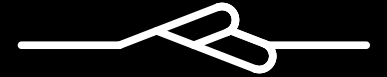

1
[0.03888889 0.13722222 0.38666667]
-1.5743101226877532


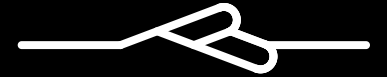

1
[0.04014815 0.1312037  0.37777778]
-1.5788528743718448


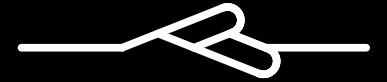

1
[0.03802469 0.13128395 0.3962963 ]
-1.5798664884438725


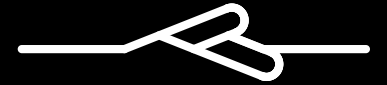

1
[0.039893   0.12443621 0.39604938]
-1.5489538148155113


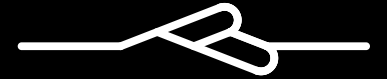

1
[0.03913992 0.13402572 0.38901235]
-1.5865130451989193


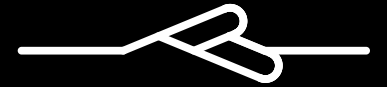

1
[0.03796159 0.13233608 0.41242798]
-1.5494486560123995


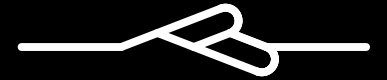

1
[0.03960151 0.1314868  0.38644033]
-1.5682738806947174


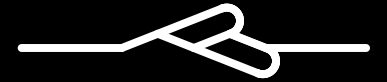

KeyboardInterrupt: 

In [8]:
from scipy.optimize import minimize
it = 0

def objective(x, it=0):
    it += 1
    w, r, dy = x

    if w <= 0 or r <= 0 or dy <= 0:
        return 1e6

    generate_valve(w, 2, dy, r, 1)

    params = {
        "png_path": "data/valve.png",
        "visualization_by": "pressure_field",
        "la": 1.03,
        "resolution_factor": 1,
        "input_vel": 0.020,
    }

    sim_f = Simulation(flip_x=True, **params)
    sim_r = Simulation(flip_x=False, **params)

    sim_f.run()
    sim_r.run()

    rf = sim_f.flow_resistance()
    rr = sim_r.flow_resistance()

    print(it)
    print(x)
    print(-rr / rf if rf > 0 else 1e6)

    return -rr / rf if rf > 0 else 1e6


x0 = [0.04, 0.13, 0.4]
bounds = [(0.03, 0.1), (0.05, 0.17), (0.25, 0.6)]

res = minimize(objective, x0, method="Nelder-Mead", bounds=bounds, options={"maxiter": 8})

print("x* =", res.x)
print("diodicity =", -res.fun)